In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

column_names = ['user_id', 'activity', 'timestamp', 'x', 'y', 'z']
label_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

# Load the WISDM dataset

data_path = '/content/drive/Shareddrives/Me and only me/Project1121/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'
wisdm_data = pd.read_csv(data_path, header=None, names=column_names, on_bad_lines='skip')

# Strip semicolon
def strip_semicolon(value):
    return value.rstrip(';') if isinstance(value, str) else value
wisdm_data['z'] = wisdm_data['z'].apply(strip_semicolon)

# Preprocessing - interpolation
wisdm_data = wisdm_data.sort_values(by=['user_id', 'timestamp'])
wisdm_data[['x', 'y', 'z']] = wisdm_data[['x', 'y', 'z']].apply(pd.to_numeric, errors='coerce')
wisdm_data = wisdm_data.interpolate()

# Scaling and normalization
scaler = StandardScaler()
wisdm_data[['x', 'y', 'z']] = scaler.fit_transform(wisdm_data[['x', 'y', 'z']])

# Preprocessing - Segmentation
def segment_data(data, window_size):
    segments = []
    labels = []
    for i in range(0, len(data) - window_size, window_size):
        segment = data.iloc[i:i + window_size]
        label = data['activity'].iloc[i + window_size - 1]
        segments.append(segment[['x', 'y', 'z']].values)
        labels.append(label)
    segments = np.array(segments, dtype=np.float32)
    label_mapping = {label: idx for idx, label in enumerate(set(labels))}
    labels = np.array([label_mapping[label] for label in labels])
    return torch.tensor(segments), torch.tensor(labels)

# Define the window size for segmentation
window_size = 128
segments, labels = segment_data(wisdm_data, window_size)

Mounted at /content/drive
Using device: cuda


In [ ]:
## WITH FILTERS & HIDDEN SIZE
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Hybrid Model
class HybridModel(nn.Module):
    def __init__(self, num_classes, num_filters, hidden_size):
        super(HybridModel, self).__init__()

        # CNN layers for spatial features
        self.cnn = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 5), stride=(1, 1), padding=(0, 2)),  # Adjusted kernel_size and stride
            nn.Conv2d(num_filters, num_filters*2, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 5), stride=(1, 1), padding=(0, 2)),  # Adjusted kernel_size and stride
            nn.Flatten()
        )

        self.cnn_output_size = (num_filters * 2) * 3  # 64 channels * 3 features


        # LSTM layers for temporal dependencies
        self.rnn = nn.LSTM(input_size=self.cnn_output_size, hidden_size=hidden_size, num_layers=2, batch_first=True, dropout=0.5)  # Modify hidden_size if needed

        # Attention Mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)  # Modify output size based on the number of classes

    def forward(self, x):
        # CNN forward pass
        x = self.cnn(x)

        # Reshape for LSTM
        batch_size = x.size(0)
        seq_len = 128  # Assuming window_size is 128
        features = 24576 // seq_len  # This should match self.cnn_output_size
        x = x.view(batch_size, seq_len, self.cnn_output_size)

        # LSTM forward pass
        x, _ = self.rnn(x)

        # Apply attention
        att_weights = self.attention(x)
        x = torch.sum(att_weights * x, dim=1)

        # Fully connected layer
        x = self.fc(x)

        return x



In [ ]:
testmodel = HybridModel(num_classes=len(label_names), num_filters=16, hidden_size=64)
print(testmodel)

HybridModel(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(1, 5), stride=(1, 1), padding=(0, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(1, 5), stride=(1, 1), padding=(0, 2), dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (rnn): LSTM(96, 64, num_layers=2, batch_first=True, dropout=0.5)
  (attention): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Softmax(dim=1)
  )
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [ ]:
import itertools
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from torch.optim.lr_scheduler import StepLR




# Prepare the full dataset
full_data = TensorDataset(torch.tensor(segments).unsqueeze(1), torch.tensor(labels))

<ipython-input-3-e189e2647a05>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_data = TensorDataset(torch.tensor(segments).unsqueeze(1), torch.tensor(labels))


In [ ]:

# Define hyperparameters
learning_rates = [0.01]
num_filters = [16]
hidden_sizes = [64]
num_epochs = 40
n_splits = 5  # Number of folds for KFold

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store results
results = []

# Define batch sizes
batch_size_train = 64
batch_size_val = 64

for lr, nf, hs in itertools.product(learning_rates, num_filters, hidden_sizes):
    print(f"Training with lr={lr}, num_filters={nf}, hidden_size={hs}")

    for fold, (train_idx, val_idx) in enumerate(kf.split(segments)):
        print(f"Fold {fold+1}/{n_splits}")

        # Initialize best results for the current fold
        best_accuracy_fold = 0
        best_hyperparameters_fold = {}

        # Split data
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        # Create DataLoaders for current split
        train_dataloader = DataLoader(full_data, batch_size=batch_size_train, sampler=train_subsampler)
        val_dataloader = DataLoader(full_data, batch_size=batch_size_val, sampler=val_subsampler)

        # Instantiate the model with current hyperparameters
        model = HybridModel(num_classes=len(label_names), num_filters=nf, hidden_size=hs).to(device)

        # Define the optimizer and loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
        criterion = nn.CrossEntropyLoss()

        # Training loop for the current fold
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0

            for inputs, labels in train_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            scheduler.step()

            # Validation evaluation
            model.eval()
            total_correct = 0
            total_samples = 0
            all_outputs = []
            all_labels = []

            with torch.no_grad():
                for inputs, labels in val_dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)

                    all_outputs.extend(outputs.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            avg_loss = total_loss / len(train_dataloader)

            probabilities = F.softmax(torch.tensor(all_outputs), dim=1).numpy()
            class_predictions = np.argmax(probabilities, axis=1)

            # Calculate metrics
            precision = precision_score(all_labels, class_predictions, average='macro', zero_division=1)
            recall = recall_score(all_labels, class_predictions, average='macro')
            f1 = f1_score(all_labels, class_predictions, average='macro')

            # Convert raw outputs to probabilities (if they aren't already probabilities)
            probabilities = np.array(all_outputs)
            # Binarize the labels
            num_classes = len(np.unique(all_labels))
            binarized_labels = label_binarize(all_labels, classes=range(len(label_names)))

            # Calculate AUROC
            try:
                if num_classes == 2:  # Binary classification
                    auroc = roc_auc_score(binarized_labels, probabilities[:, 1])  # Use probabilities of the positive class
                else:  # Multiclass classification
                    auroc = roc_auc_score(binarized_labels, probabilities, multi_class='ovr')
            except ValueError as e:
                print("Error calculating AUROC: ", e)
                auroc = None

            accuracy = precision_score(all_labels, np.argmax(probabilities, axis=1), average='micro')
            if accuracy > best_accuracy_fold:
                best_accuracy_fold = accuracy
                best_hyperparameters_fold = {
                    'learning_rate': lr,
                    'num_filters': nf,
                    'hidden_size': hs,
                    'fold_accuracy': accuracy
                }
            print(f'Fold {fold+1}, Epoch [{epoch+1}/{num_epochs}], Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUROC: {auroc:.4f}, Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}')

        # Print best results for the current fold
        print(f"\nBest Results for Fold {fold+1}:")
        print(f"Learning Rate: {best_hyperparameters_fold['learning_rate']}")
        print(f"Number of Filters: {best_hyperparameters_fold['num_filters']}")
        print(f"Hidden Size: {best_hyperparameters_fold['hidden_size']}")
        print(f"Validation Accuracy: {best_hyperparameters_fold['fold_accuracy']}\n")

        # Store the results for the current fold
        results.append({
            'fold': fold+1,
            'learning_rate': lr,
            'num_filters': nf,
            'hidden_size': hs,
            'accuracy': accuracy
        })

# Find the best hyperparameters based on validation accuracy
best_result = max(results, key=lambda x: x['accuracy'])

# Print the best hyperparameters
print("\nBest Hyperparameters:")
print("Fold:", best_result['fold'])
print("Learning Rate:", best_result['learning_rate'])
print("Number of Filters:", best_result['num_filters'])
print("Hidden Size:", best_result['hidden_size'])
print("Validation Accuracy:", best_result['accuracy'])


Training with lr=0.01, num_filters=16, hidden_size=64
Fold 1/5
Fold 1, Epoch [1/40], Precision: 0.7117, Recall: 0.5789, F1: 0.5359, AUROC: 0.8907, Loss: 1.0121, Validation Accuracy: 0.6920
Fold 1, Epoch [2/40], Precision: 0.8008, Recall: 0.7101, F1: 0.6692, AUROC: 0.9121, Loss: 0.6307, Validation Accuracy: 0.7721
Fold 1, Epoch [3/40], Precision: 0.7617, Recall: 0.6839, F1: 0.6835, AUROC: 0.9439, Loss: 0.5127, Validation Accuracy: 0.7809
Fold 1, Epoch [4/40], Precision: 0.8005, Recall: 0.7754, F1: 0.7830, AUROC: 0.9549, Loss: 0.4194, Validation Accuracy: 0.8310
Fold 1, Epoch [5/40], Precision: 0.7938, Recall: 0.7782, F1: 0.7739, AUROC: 0.9548, Loss: 0.3671, Validation Accuracy: 0.8115
Fold 1, Epoch [6/40], Precision: 0.8100, Recall: 0.7952, F1: 0.7953, AUROC: 0.9626, Loss: 0.3606, Validation Accuracy: 0.8439
Fold 1, Epoch [7/40], Precision: 0.8034, Recall: 0.8121, F1: 0.8071, AUROC: 0.9620, Loss: 0.3355, Validation Accuracy: 0.8504
Fold 1, Epoch [8/40], Precision: 0.8202, Recall: 0.8036

Evaluate Final Model

In [ ]:

import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Assuming optimal hyperparameters are stored in these variables
optimal_lr = 0.01  # replace with your optimal learning rate
optimal_num_filters = 16  # replace with your optimal number of filters
optimal_hidden_size = 64  # replace with your optimal hidden size

# Create the model with optimal hyperparameters
final_model = HybridModel(num_classes=len(label_names), num_filters=optimal_num_filters, hidden_size=optimal_hidden_size).to(device)

# Optimizer with optimal learning rate
optimizer = optim.Adam(final_model.parameters(), lr=optimal_lr)

# Loss function
criterion = nn.CrossEntropyLoss()

# Define the window size for segmentation
window_size = 128
segments, labels = segment_data(wisdm_data, window_size)

# Prepare the full dataset
full_data = TensorDataset(torch.tensor(segments).unsqueeze(1), torch.tensor(labels))

# Define batch size for training data
batch_size_train = 64  # You can adjust this based on your preference

# Lists to store metrics for plotting
train_losses = []
val_losses = []
precisions = []
recalls = []
f1_scores = []
aurocs = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    final_model.train()
    total_loss = 0
    all_labels_train = []
    all_predictions_train = []

    # Training phase
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for later metric calculation
        predictions = torch.argmax(outputs, dim=1)
        all_labels_train.extend(labels.cpu().numpy())
        all_predictions_train.extend(predictions.cpu().numpy())

    scheduler.step()
    # Calculate metrics for the training set
    precision_train = precision_score(all_labels_train, all_predictions_train, average='weighted')
    recall_train = recall_score(all_labels_train, all_predictions_train, average='weighted')
    f1_train = f1_score(all_labels_train, all_predictions_train, average='weighted')

    # Calculate AUROC for the validation set
    final_model.eval()
    all_labels_val = []
    all_probabilities_val = []
    all_predictions_val = []

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = final_model(inputs)
            predictions = torch.softmax(outputs, dim=1)[:, 1]
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            all_labels_val.extend(labels.cpu().numpy())
            all_probabilities_val.extend(probabilities)

    # Assuming binary classification for simplicity
    if len(label_names) == 2:
        auroc_val = roc_auc_score(all_labels_val, all_probabilities_val[:, 1])
    else:
        # For multi-class, you need to use 'roc_auc_ovr' since 'ovr' is not supported directly
        auroc_val = roc_auc_score(all_labels_val, all_probabilities_val, multi_class='ovr', average='weighted')

    # Calculate validation accuracy
    predicted_labels_val = np.argmax(all_probabilities_val, axis=1)

    # Calculate accuracy for the validation set
    val_accuracy = accuracy_score(all_labels_val, predicted_labels_val)


    # Calculate validation loss
    val_loss = criterion(outputs, labels).item()

    # Print and store metrics
    print(f'Epoch {epoch+1}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1: {f1_train:.4f}, AUROC (Validation): {auroc_val:.4f}, Loss: {total_loss / len(train_dataloader):.4f}, Validation Accuracy: {val_accuracy:.4f}')

    train_losses.append(total_loss / len(train_dataloader))
    val_losses.append(val_loss)
    precisions.append(precision_train)
    recalls.append(recall_train)
    f1_scores.append(f1_train)
    aurocs.append(auroc_val)
    val_accuracies.append(val_accuracy)

<ipython-input-72-e3062b2203ed>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_data = TensorDataset(torch.tensor(segments).unsqueeze(1), torch.tensor(labels))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Precision: 0.4934, Recall: 0.6030, F1: 0.5186, AUROC (Validation): 0.9108, Loss: 1.1150, Validation Accuracy: 0.7272
Epoch 2, Precision: 0.6794, Recall: 0.7372, F1: 0.6827, AUROC (Validation): 0.9513, Loss: 0.7122, Validation Accuracy: 0.8020
Epoch 3, Precision: 0.7863, Recall: 0.8083, F1: 0.7903, AUROC (Validation): 0.9670, Loss: 0.5133, Validation Accuracy: 0.8309
Epoch 4, Precision: 0.7889, Recall: 0.8075, F1: 0.7935, AUROC (Validation): 0.9700, Loss: 0.5142, Validation Accuracy: 0.8362
Epoch 5, Precision: 0.8229, Recall: 0.8361, F1: 0.8273, AUROC (Validation): 0.9743, Loss: 0.4514, Validation Accuracy: 0.8521
Epoch 6, Precision: 0.8533, Recall: 0.8608, F1: 0.8563, AUROC (Validation): 0.9753, Loss: 0.3803, Validation Accuracy: 0.8680
Epoch 7, Precision: 0.8662, Recall: 0.8701, F1: 0.8678, AUROC (Validation): 0.9779, Loss: 0.3675, Validation Accuracy: 0.8745
Epoch 8, Precision: 0.8664, Recall: 0.8712, F1: 0.8682, AUROC (Validation): 0.9755, Loss: 0.3564, Validation Accuracy:

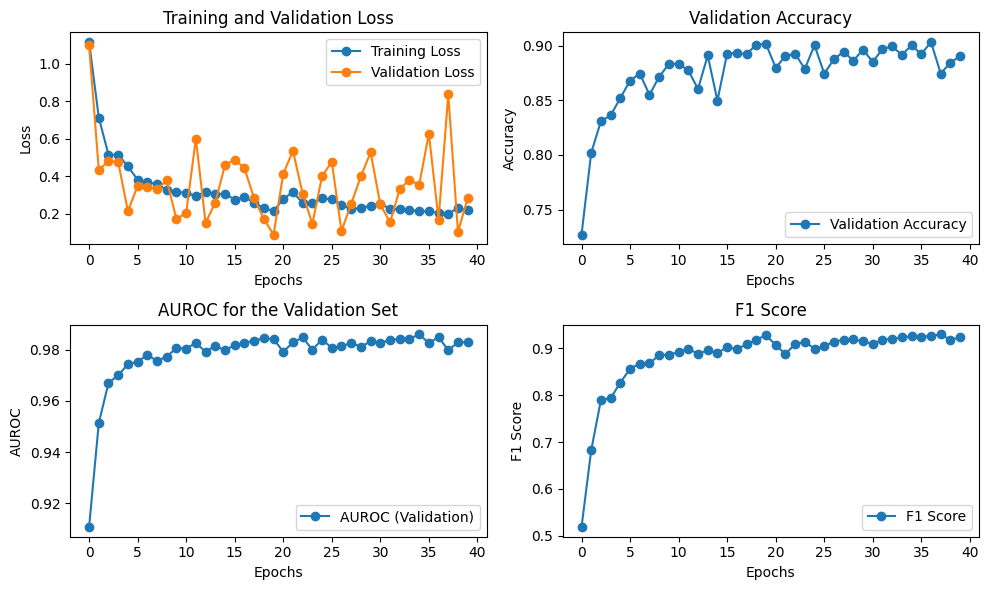

In [ ]:
    import torch.optim as optim
    from torch.utils.data import TensorDataset, DataLoader
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score


# Plotting metrics after each epoch
    plt.figure(figsize=(10, 6))

    # Loss plot
    plt.subplot(2, 2, 1)
    plt.plot(range(epoch+1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(epoch+1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(2, 2, 2)
    plt.plot(range(epoch+1), val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # AUROC plot
    plt.subplot(2, 2, 3)
    plt.plot(range(epoch+1), aurocs, label='AUROC (Validation)', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('AUROC')
    plt.title('AUROC for the Validation Set')
    plt.legend()

    # F1 score plot
    plt.subplot(2, 2, 4)
    plt.plot(range(epoch+1), f1_scores, label='F1 Score', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:

import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score

# Assuming optimal hyperparameters are stored in these variables
optimal_lr = 0.01  # replace with your optimal learning rate
optimal_num_filters = 16  # replace with your optimal number of filters
optimal_hidden_size = 64  # replace with your optimal hidden size

# Create the model with optimal hyperparameters
final_model = HybridModel(num_classes=len(label_names), num_filters=optimal_num_filters, hidden_size=optimal_hidden_size).to(device)

# Optimizer with optimal learning rate
optimizer = optim.Adam(final_model.parameters(), lr=optimal_lr)

# Loss function
criterion = nn.CrossEntropyLoss()

# Define the window size for segmentation
window_size = 128
segments, labels = segment_data(wisdm_data, window_size)

# Prepare the full dataset
full_data = TensorDataset(torch.tensor(segments).unsqueeze(1), torch.tensor(labels))

# Define batch size for training data
batch_size_train = 64  # You can adjust this based on your preference

# Lists to store metrics for plotting
train_losses = []
val_losses = []
precisions = []
recalls = []
f1_scores = []
aurocs = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    final_model.train()
    total_loss = 0
    all_labels_train = []
    all_predictions_train = []

    # Training phase
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for later metric calculation
        predictions = torch.argmax(outputs, dim=1)
        all_labels_train.extend(labels.cpu().numpy())
        all_predictions_train.extend(predictions.cpu().numpy())

    scheduler.step()
    # Calculate metrics for the training set
    precision_train = precision_score(all_labels_train, all_predictions_train, average='weighted')
    recall_train = recall_score(all_labels_train, all_predictions_train, average='weighted')
    f1_train = f1_score(all_labels_train, all_predictions_train, average='weighted')

    probabilities = F.softmax(torch.tensor(all_outputs), dim=1).numpy()
    probabilities = np.array(all_outputs)

    # Calculate AUROC for the validation set
    if num_classes == 2:  # Binary classification
      auroc_val = roc_auc_score(binarized_labels, probabilities[:, 1])  # Use probabilities of the positive class
    else:  # Multiclass classification
      auroc_val = roc_auc_score(binarized_labels, probabilities, multi_class='ovr')

    #auroc_val = calculate_auroc(final_model, val_dataloader, device)

    # Calculate validation accuracy
    final_model.eval()
    all_labels_val = []
    all_predictions_val = []
    all_outputs = []

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = final_model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            all_outputs.extend(outputs.cpu().numpy())
            all_labels_val.extend(labels.cpu().numpy())
            all_predictions_val.extend(predictions.cpu().numpy())

    val_accuracy = accuracy_score(all_labels_val, all_predictions_val)

    # Calculate validation loss
    val_loss = criterion(outputs, labels).item()

    # Print and store metrics
    print(f'Epoch {epoch+1}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1: {f1_train:.4f}, AUROC (Validation): {auroc_val:.4f}, Loss: {total_loss / len(train_dataloader):.4f}, Validation Accuracy: {val_accuracy:.4f}')

    train_losses.append(total_loss / len(train_dataloader))
    val_losses.append(val_loss)
    precisions.append(precision_train)
    recalls.append(recall_train)
    f1_scores.append(f1_train)
    aurocs.append(auroc_val)
    val_accuracies.append(val_accuracy)



In [ ]:
# Save the model
torch.save(final_model.state_dict(), '/content/drive/Shareddrives/Me and only me/Project1121/1219MODEL.pth')

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Define the window size for segmentation
window_size = 128
segments, labels = segment_data(wisdm_data, window_size)

# Split Data Into Train, Validation, and Test sets
torch.manual_seed(42)
X = segments
y = labels
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Add channel dimension and move data to the device (GPU or CPU)
X_train = X_train.unsqueeze(1).to(device)
X_val = X_val.unsqueeze(1).to(device)
X_test = X_test.unsqueeze(1).to(device)
y_train = y_train.to(device)
y_val = y_val.to(device)
y_test = y_test.to(device)

print("X_test size:", X_test.size())
print("y_test size:", y_test.size())


X_test size: torch.Size([1274, 1, 128, 3])
y_test size: torch.Size([1274])


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# Assuming these variables are defined elsewhere
best_accuracy_fold = None
lr = None
nf = None
hs = None
label_names = np.unique(y_test.cpu().numpy())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available


def evaluate_model(model, val_dataloader, all_labels, best_accuracy_fold, lr, nf, hs, label_names):
    model.eval()
    total_loss = 0
    all_outputs = []

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item()

            all_outputs.extend(outputs.cpu().detach().numpy())

    avg_loss = total_loss / len(val_dataloader)

    probabilities = F.softmax(torch.tensor(all_outputs), dim=1).cpu().detach().numpy()
    class_predictions = np.argmax(probabilities, axis=1)

    # Calculate metrics
    precision = precision_score(all_labels.cpu().numpy(), class_predictions, average='macro', zero_division=1)
    recall = recall_score(all_labels.cpu().numpy(), class_predictions, average='macro')
    f1 = f1_score(all_labels.cpu().numpy(), class_predictions, average='macro')

    # Convert raw outputs to probabilities (if they aren't already probabilities)
    probabilities = np.array(all_outputs)
    # Binarize the labels
    num_classes = len(np.unique(all_labels.cpu().numpy()))
    binarized_labels = label_binarize(all_labels.cpu().numpy(), classes=range(len(label_names)))



    # Calculate AUROC
    try:
        if num_classes == 2:  # Binary classification
            auroc = roc_auc_score(binarized_labels, probabilities[:, 1])  # Use probabilities of the positive class
        else:  # Multiclass classification
            auroc = roc_auc_score(binarized_labels, probabilities, multi_class='ovr')
    except ValueError as e:
        print("Error calculating AUROC: ", e)
        auroc = None

    accuracy = accuracy_score(all_labels.cpu().numpy(), np.argmax(probabilities, axis=1))

    if best_accuracy_fold is not None and lr is not None and nf is not None and hs is not None:
        if accuracy > best_accuracy_fold:
            best_accuracy_fold = accuracy
            best_hyperparameters_fold = {
                'learning_rate': lr,
                'num_filters': nf,
                'hidden_size': hs,
                'fold_accuracy': accuracy
            }
            print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUROC: {auroc:.4f}, Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}')

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auroc': auroc
    }

# Assuming X_test and y_test are your test data
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
batch_size_test = 64  # You can adjust this based on your preference
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size_test, shuffle=False)

# Evaluate the final model
test_metrics = evaluate_model(
    model=final_model,
    val_dataloader=test_dataloader,
    all_labels=y_test,
    best_accuracy_fold=best_accuracy_fold,
    lr=lr,
    nf=nf,
    hs=hs,
    label_names=label_names
)

print("Test Loss:", test_metrics['loss'])
print("Test Accuracy:", test_metrics['accuracy'])
print("Test Precision:", test_metrics['precision'])
print("Test Recall:", test_metrics['recall'])
print("Test F1 Score:", test_metrics['f1'])
print("Test AUROC:", test_metrics['auroc'])


Test Loss: 0.2915025264024734
Test Accuracy: 0.9081632653061225
Test Precision: 0.8825900760760552
Test Recall: 0.8619316491512011
Test F1 Score: 0.866072699434508
Test AUROC: 0.9747119502403065


<ipython-input-35-328f0d0f2263>:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
